Loading mapping from Data/attack2category_map.txt...
Successfully loaded 40 mappings.

Loading dataset from Data/network_connections.csv...
Original Dataset Shape: (125973, 42)
Duplicates dropped: 0
New Dataset Shape: (125973, 42)
   duration protocol_type   service flag  src_bytes  dst_bytes  land  \
0         0           tcp  ftp_data   SF        491          0     0   
1         0           udp     other   SF        146          0     0   
2         0           tcp   private   S0          0          0     0   
3         0           tcp      http   SF        232       8153     0   
4         0           tcp      http   SF        199        420     0   

   wrong_fragment  urgent  hot  ...  dst_host_srv_count  \
0               0       0    0  ...                  25   
1               0       0    0  ...                   1   
2               0       0    0  ...                  26   
3               0       0    0  ...                 255   
4               0       0    0  ...      

/mnt/d/Software Projekte/Intellj/IdeaProjects/AIandSec_Project3/.venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


   Specific CV Accuracy: 0.9984 (+/- 0.0003)
----------------------------------------
--- Training Final Model for Task 1 (Categories) ---

Task 1 Accuracy: 0.9986

Classification Report (Categories):
              precision    recall  f1-score   support

         dos       1.00      1.00      1.00     13778
      normal       1.00      1.00      1.00     20203
       probe       1.00      0.99      1.00      3497
         r2l       1.00      0.95      0.97       298
         u2r       0.89      0.50      0.64        16

    accuracy                           1.00     37792
   macro avg       0.98      0.89      0.92     37792
weighted avg       1.00      1.00      1.00     37792



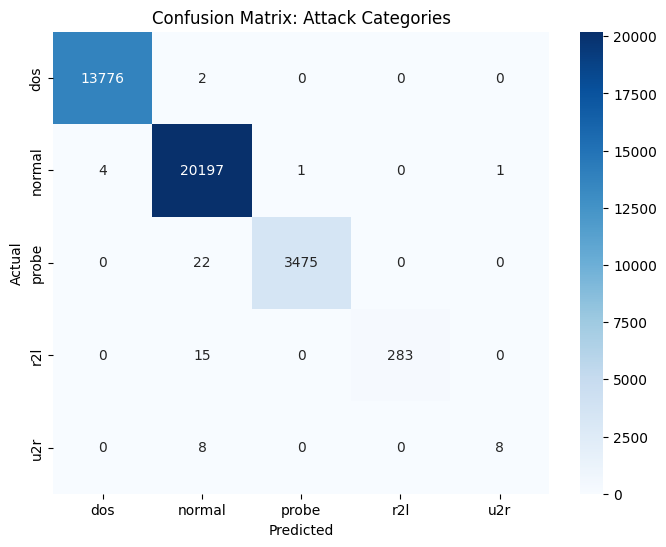

--- Training Final Model for Task 2 (Specific Attacks) ---

Task 2 (Advanced) Accuracy: 0.9980

Comparison:
Category Accuracy: 0.9986
Specific Accuracy: 0.9980
Difference: -0.0006

Classification Report (Specific Attacks - Top 15 classes by Support):
                 precision    recall  f1-score  support
macro avg         0.833876  0.755798  0.778616  37792.0
weighted avg      0.997894  0.997989  0.997890  37792.0
normal            0.997432  0.999555  0.998492  20203.0
neptune           0.999838  1.000000  0.999919  12326.0
satan             0.997248  0.981933  0.989531   1107.0
ipsweep           0.993464  0.992537  0.993000   1072.0
portsweep         0.998864  0.990981  0.994907    887.0
smurf             1.000000  1.000000  1.000000    813.0
nmap              0.986175  0.993039  0.989595    431.0
back              0.996700  1.000000  0.998347    302.0
teardrop          1.000000  1.000000  1.000000    276.0
warezclient       1.000000  0.958015  0.978558    262.0
pod               1.0

/mnt/d/Software Projekte/Intellj/IdeaProjects/AIandSec_Project3/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/mnt/d/Software Projekte/Intellj/IdeaProjects/AIandSec_Project3/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/mnt/d/Software Projekte/Intellj/IdeaProjects/AIandSec_Project3/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted sa

In [3]:
# %% [markdown]
# # AI & Security: Project 3 - Network Intrusion Detection
# **Student Name:** [Your Name]
#
# ## Project Overview
# This notebook builds a Network Intrusion Detection System (NIDS) using the provided dataset.
#
# **Implemented Features:**
# * **Task 1:** 5-Class Classification (Normal, DoS, Probe, R2L, U2R).
# * **Task 2:** Specific Attack Prediction (e.g., Smurf, Neptune).
# * **Best Practices:**
#     * **Duplicate Removal:** Prevents data leakage and overfitting.
#     * **Class Balancing:** Improves detection of rare attacks (e.g., U2R).
#     * **Cross-Validation:** Verifies model stability across 5 different data splits.

# %%
# 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# %% [markdown]
# ## 2. Load Data and Mappings
# We load the connection data and the attack-to-category mapping file from the 'Data' folder.

# %%
# Define file paths
DATA_DIR = 'Data'
CSV_FILE = os.path.join(DATA_DIR, 'network_connections.csv')
MAP_FILE = os.path.join(DATA_DIR, 'attack2category_map.txt')

# --- Step A: Load the Mapping File ---
print(f"Loading mapping from {MAP_FILE}...")
attack_map = {}
try:
    with open(MAP_FILE, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) >= 2:
                # Format: specific_attack category
                attack_map[parts[0]] = parts[1]
    
    # Ensure 'normal' is in the map
    if 'normal' not in attack_map:
        attack_map['normal'] = 'normal'
        
    print(f"Successfully loaded {len(attack_map)} mappings.")
    
except FileNotFoundError:
    print("ERROR: Map file not found. Please check the path.")

# --- Step B: Load the Dataset ---
print(f"\nLoading dataset from {CSV_FILE}...")
try:
    # Load data (Using header=0 based on standard csv format)
    df = pd.read_csv(CSV_FILE, header=0)
    
    # Clean label column (remove trailing periods if they exist)
    df['label'] = df['label'].astype(str).str.replace('.', '', regex=False)
    
    print(f"Original Dataset Shape: {df.shape}")
    
    # --- IMPROVEMENT 1: Drop Duplicates ---
    # KDD Cup 99 data is known for having many duplicates which cause overfitting.
    # Removing them ensures the model learns general patterns, not just memorizing frequent rows.
    before = df.shape[0]
    df.drop_duplicates(inplace=True)
    after = df.shape[0]
    print(f"Duplicates dropped: {before - after}")
    print(f"New Dataset Shape: {df.shape}")

    print(df.head())
except FileNotFoundError:
    print("ERROR: CSV file not found. Please check the path.")

# %% [markdown]
# ## 3. Data Preprocessing
# * **Mapping:** Create the broad `category` column (DoS, Probe, etc.).
# * **Encoding:** Convert text features to numbers.

# %%
# 1. Apply Attack Category Mapping
df['category'] = df['label'].map(attack_map)

# Fill missing categories
missing_cats = df[df['category'].isna()]['label'].unique()
if len(missing_cats) > 0:
    print(f"Warning: The following labels were not in the map file: {missing_cats}")
    df['category'] = df['category'].fillna('other')

print("\nClass Distribution (Categories):")
print(df['category'].value_counts())

# 2. Encode Categorical Features
categorical_cols = ['protocol_type', 'service', 'flag']

# Create feature matrix X and target vectors y
X = df.drop(['label', 'category'], axis=1)
y_category = df['category']  # Target for Task 1
y_specific = df['label']     # Target for Task 2

# Label Encoding
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))

# 3. Split Data
# Stratify ensures we keep the same proportion of attack types in Train and Test
X_train, X_test, y_cat_train, y_cat_test, y_spec_train, y_spec_test = train_test_split(
    X, y_category, y_specific, test_size=0.3, random_state=42, stratify=y_category
)

# 4. Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("\nData Split Complete.")
print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")

# %% [markdown]
# ## 4. Cross-Validation (Robustness Check)
# Before training the final model, we perform 5-Fold Cross-Validation.
# This splits the data into 5 parts and tests the model 5 times to ensure the accuracy is stable and not just luck.

# %%
print("--- Performing 5-Fold Cross-Validation ---")

# Initialize a temporary classifier for CV
# We use fewer trees (n_estimators=50) here just to speed up the check
clf_cv = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1, class_weight='balanced')

# 1. CV for Category Task
print("1. Evaluating Category Model (5-Fold)...")
# Note: We use the full encoded X and y here, as CV handles the splitting
scores_cat = cross_val_score(clf_cv, X, y_category, cv=5, scoring='accuracy')
print(f"   Category CV Accuracy: {scores_cat.mean():.4f} (+/- {scores_cat.std() * 2:.4f})")

# 2. CV for Specific Attack Task
print("2. Evaluating Specific Attack Model (5-Fold)...")
scores_spec = cross_val_score(clf_cv, X, y_specific, cv=5, scoring='accuracy')
print(f"   Specific CV Accuracy: {scores_spec.mean():.4f} (+/- {scores_spec.std() * 2:.4f})")
print("-" * 40)

# %% [markdown]
# ## Task 1: Standard Classification (5 Categories)
# Build a model to classify connections as: **Normal, DoS, Probe, R2L, or U2R**.
# * **Improvement:** Used `class_weight='balanced'` to pay more attention to rare attacks (U2R).

# %%
print("--- Training Final Model for Task 1 (Categories) ---\n")
clf_cat = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight='balanced')
clf_cat.fit(X_train, y_cat_train)

# Predictions
y_cat_pred = clf_cat.predict(X_test)

# Evaluation
acc_cat = accuracy_score(y_cat_test, y_cat_pred)
print(f"Task 1 Accuracy: {acc_cat:.4f}")

print("\nClassification Report (Categories):")
print(classification_report(y_cat_test, y_cat_pred))

# Visualization
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_cat_test, y_cat_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=clf_cat.classes_, yticklabels=clf_cat.classes_)
plt.title('Confusion Matrix: Attack Categories')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# %% [markdown]
# ## Task 2: Advanced Classification (Specific Attacks)
# Predict specific attack names.
# * **Improvement:** `class_weight='balanced'` helps significantly with rare attacks that have very few samples.

# %%
print("--- Training Final Model for Task 2 (Specific Attacks) ---\n")
clf_spec = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight='balanced')
clf_spec.fit(X_train, y_spec_train)

# Predictions
y_spec_pred = clf_spec.predict(X_test)

# Evaluation
acc_spec = accuracy_score(y_spec_test, y_spec_pred)
print(f"Task 2 (Advanced) Accuracy: {acc_spec:.4f}")

print("\nComparison:")
print(f"Category Accuracy: {acc_cat:.4f}")
print(f"Specific Accuracy: {acc_spec:.4f}")
print(f"Difference: {acc_spec - acc_cat:.4f}")

print("\nClassification Report (Specific Attacks - Top 15 classes by Support):")
report = classification_report(y_spec_test, y_spec_pred, output_dict=True)
# Sort by 'support' (number of samples) to see the most common attacks first
report_df = pd.DataFrame(report).transpose().sort_values(by='support', ascending=False).head(15)
print(report_df)